In [1]:
import numpy as np
import matplotlib.pyplot as plt

from keras.optimizers import Adam
from keras import backend as K
from keras.layers import Layer, Input, Conv2D, BatchNormalization
from keras.regularizers import l2
from keras.models import Model

from pathlib import Path
import cv2
import os
import imgaug as ia
import imgaug.augmenters as iaa
from tqdm import tqdm

Using TensorFlow backend.


In [2]:
model_dir = "models"
model_name = "denoising-4"
weights_name = "e77.h5"

n = 10
normalize = True
batchnorm_at_end = True
proximal_enabled = False

train_dir = Path(os.path.join("BSR", "BSDS500", "data", "images", "train"))
test_dir = Path(os.path.join("BSR", "BSDS500", "data", "images", "test"))
val_dir = Path(os.path.join("BSR", "BSDS500", "data", "images", "val"))

noisy_train_dir = Path(os.path.join("images_noisy", "train"))
noisy_test_dir = Path(os.path.join("images_noisy", "test"))
noisy_val_dir = Path(os.path.join("images_noisy", "val"))

In [3]:
########################################################

# Custom Keras Layers:

# Proximal gradient layer
class ProximalGradient(Layer):
    C_0 = None
    C_k = None
    sigma = None

    def __init__(self, sigma, C_0, C_k, **kwargs):
        self.sigma = sigma
        self.C_0 = C_0
        self.C_k = C_k
        self.c_kernel = None
        super(ProximalGradient, self).__init__(**kwargs)

    def build(self, input_shape):
        # assert isinstance(input_shape, list)
        self.c_kernel = self.add_weight(name='c_kernel', shape=(2,), initializer='zeros', trainable=True)
        super(ProximalGradient, self).build(input_shape)

    def call(self, inputs, **kwargs):
        # assert isinstance(x, list)
        x_k, x_k_12, y = inputs

        alpha_k = (self.c_kernel[0] + self.C_0) * (self.c_kernel[1] + self.C_k)  # check on this implementation
        x_k_1 = self.sigma ** 2 / (alpha_k + self.sigma ** 2) * (alpha_k / self.sigma ** 2 * y + x_k + x_k_12)

        return x_k_1

    def compute_output_shape(self, input_shape):
        # assert isinstance(input_shape, list)
        return input_shape

In [4]:
########################################################

# Image processing:

# Function to display images
def showImage(image, title="", normalized=False, save=False):
    # if normalized, then undo normalization:
    if normalized:
        image = 255 * image
        image = image.astype(np.uint8)
    
    if save == True:
        cv2.imwrite(title + ".png", image)
    plt.figure(figsize=(8, 6))
    plt.imshow(cv2.cvtColor(image.astype('uint8'), cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.show()

In [5]:
# Create dict to hold (ground truth) images

images = {
    'train': [],
    'test': [],
    'val': []
}

# Add images to the dict
for image in tqdm(sorted(os.listdir(train_dir))):
    if '.jpg' in image:  # only add .jpg files
        images['train'] += [cv2.imread(str(train_dir) + "/" + image)]

for image in tqdm(sorted(os.listdir(test_dir))):
    if '.jpg' in image:  # only add .jpg files
        images['test'] += [cv2.imread(str(test_dir) + "/" + image)]

for image in tqdm(sorted(os.listdir(val_dir))):
    if '.jpg' in image:  # only add .jpg files
        images['val'] += [cv2.imread(str(val_dir) + "/" + image)]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:00<00:00, 377.81it/s]


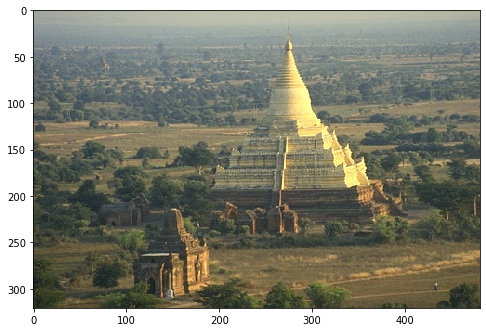

(321, 481, 3)


In [6]:
showImage(images['val'][90])
print(images['val'][90].shape)

In [7]:
images_noisy = {
    'train': [],
    'test': [],
    'val': []
}

# Add images to the dict
for image in tqdm(sorted(os.listdir(noisy_train_dir))):
    if '.jpg' in image:  # only add .jpg files
        images_noisy['train'] += [cv2.imread(str(noisy_train_dir) + "/" + image)]

for image in tqdm(sorted(os.listdir(noisy_test_dir))):
    if '.jpg' in image:  # only add .jpg files
        images_noisy['test'] += [cv2.imread(str(noisy_test_dir) + "/" + image)]

for image in tqdm(sorted(os.listdir(noisy_val_dir))):
    if '.jpg' in image:  # only add .jpg files
        images_noisy['val'] += [cv2.imread(str(noisy_val_dir) + "/" + image)]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 387.26it/s]


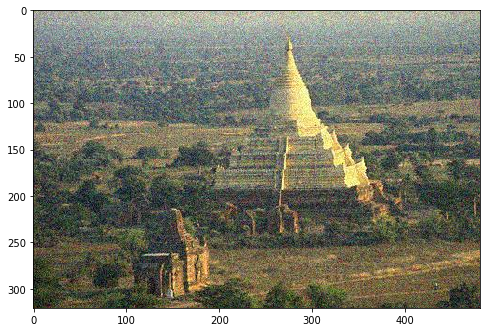

(321, 481, 3)


In [8]:
showImage(images_noisy['val'][90])
print(images_noisy['val'][90].shape)

Build the CNN part of the algorithm:

In [9]:
########################################################

# Building and compiling the model

def createCNN(input_, weight_decay, n=7, batchnorm_at_end=False):
    # initial input layer
    layers = input_

    # Add the n-2 conv layers with 64 channels
    for n_ in range(n - 1):
        if n_ == 0:
            layers = Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same',
                            kernel_regularizer=l2(weight_decay))(layers)
            if not batchnorm_at_end:
                layers = BatchNormalization(axis=-1)(layers)
        else:
            layers = Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same')(layers)
            if not batchnorm_at_end:
                layers = BatchNormalization(axis=-1)(layers)

    # Add the conv layer with 3 channels
    layers = Conv2D(3, kernel_size=(3, 3), activation='relu', padding='same')(layers)
    if batchnorm_at_end:
        layers = BatchNormalization(axis=-1)(layers)

    return layers

Tie the CNN network(s) with the proximal gradient layers

In [10]:
N = 4
sigma = 25
C_0 = 0
C_k = 1
weight_decay = 0.0001

# initialization: x_0
y = Input(shape=(180, 180, 3))
x_0 = y

x_k = None
x_k_1 = None
for k in range(N):
    if k == 0:
        x_k = x_0
        cnn_net = createCNN(x_0, weight_decay, n=n, batchnorm_at_end=batchnorm_at_end)
    else:
        cnn_net = createCNN(x_k, weight_decay, n=n, batchnorm_at_end=batchnorm_at_end)

    if proximal_enabled:
        x_k_1 = ProximalGradient(sigma, C_0, C_k=2 ** -k)([x_k, cnn_net, y])
        # use x_{k+1} as the input to the next CNN in the loop
        x_k = x_k_1
    else:
        x_k = cnn_net

# create the model
model = Model(y, x_k_1 if proximal_enabled else x_k)
print(model.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 180, 180, 64)      1792      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 180, 180, 64)      36928     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 180, 180, 64)      36928     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 180, 180, 64)      36928     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 180, 180, 64)      36928     
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 180, 180, 64)      3692

In [11]:
# load weights into new model
if weights_name == "LAST":
    # find the last-named file:
    weights_name = sorted([c for c in os.listdir(os.path.join(model_dir, model_name)) if ".h5" in c], 
                          key=lambda s: int(s[1:].split(".h5")[0]))[-1]
    
model.load_weights(os.path.join(model_dir, model_name, weights_name))
print("Loaded model from disk: {}".format(weights_name))

Loaded model from disk: e77.h5


In [12]:
# compile the model with a loss function:

# adding PSNR to list of metrics
def PSNR(y_true, y_pred):
    max_pixel = 1.0
    return (10.0 * K.log((max_pixel ** 2) / (K.mean(K.square(y_pred - y_true + 1e-8), axis=-1)))) / 2.303

metrics = [PSNR]
adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999)
model.compile(loss='mean_squared_error', metrics=metrics, optimizer=adam)

In [13]:
# evaluate the model:

# define training sets
x_set = images_noisy['train']
y_set = images['train']

# image cropping
crop_this = iaa.Sequential([
  iaa.CropToFixedSize(width=180, height=180, position="uniform")
])
ia.seed(1)
x_input = np.array(crop_this(images=x_set))
ia.seed(1)
y_input = np.array(crop_this(images=y_set))

# normalize
if normalize:
    x_input = x_input.astype('float32')
    x_input = x_input / 255.0

    y_input = y_input.astype('float32')
    y_input = y_input / 255.0

In [14]:
# model evals
x_hat = model.predict(x_input)
errors = model.evaluate(x_input, y_input)

200/200 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 4s 19ms/step


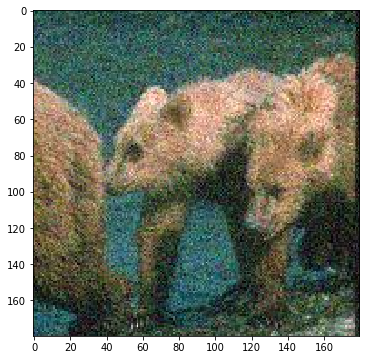

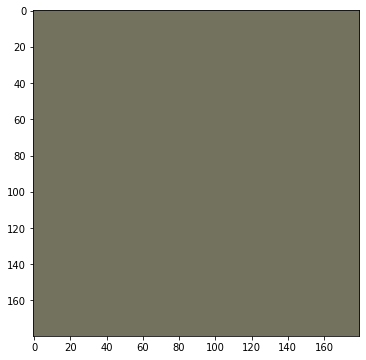

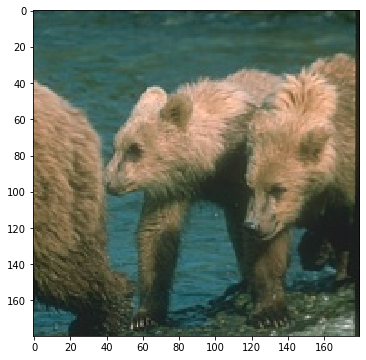

In [15]:
# show sample image
showImage(x_input[0], normalized=normalize)
showImage(x_hat[0], normalized=normalize)
showImage(y_input[0], normalized=normalize)